In [2]:
import torch
import torch.distributions as dist
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import make_grid

%matplotlib inline

In [3]:
mnist_train = MNIST(root='data/', download=True, train=True, transform=transforms.ToTensor())

In [4]:
train_loader = DataLoader(mnist_train, batch_size=100, shuffle=True)

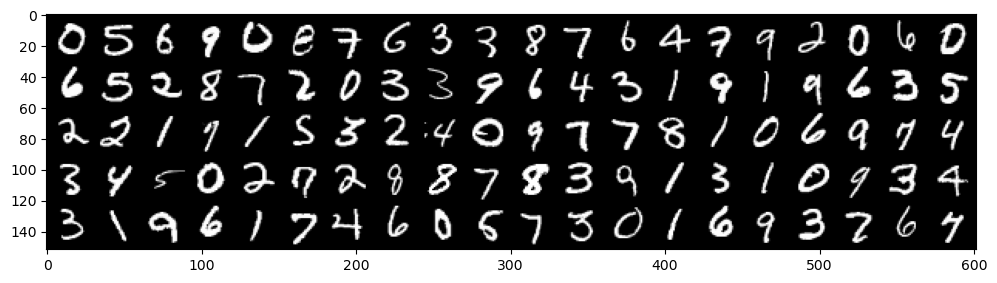

In [5]:
def get_random_batch():
    for X, y in train_loader:
        break
    return X, y

plt.figure(figsize=(12,4));
X, y = get_random_batch()
plt.imshow(make_grid(X, nrow=20).permute((1,2,0)));

# Version 1: Feedforward network, autodiff only

In [6]:
# Model: h = relu(Ax + b); y ~= Categorical(softmax(Ch + d));
#
# Data dimension: 28x28 pixels = 784
# Number of hidden units H: 400 (?)
# Output dimension: 10 classes

H = 200
D = 28 * 28
L = 10
# params = (A, b, C, d)
params = (torch.randn(H, D, requires_grad=True), 
          torch.randn(H, requires_grad=True), 
          torch.randn(L, H, requires_grad=True), 
          torch.randn(L, requires_grad=True))


In [7]:
def predict_class(X, params):
    """ Run the model forward to output a class prediction """
    A, b, C, d = params
    # X is [N x D], batch size N
    h = torch.relu(X.reshape(-1, 784) @ A.T + b)
    y = h @ C.T + d
    # NOTE: it's not necessary to actually include the softmax here!
    return y

def check_accuracy(X, params, y):
    return (predict_class(X, params).argmax(-1) == y)


In [8]:
# This should be "batch size" by "output size"

predict_class(X, params).shape

torch.Size([100, 10])

In [9]:
# The accuracy of a random classifier should be about 10%

check_accuracy(X, params, y).float().mean().item()

0.05000000074505806

In [10]:
# We can create a categorical distribution from either a probability vector, 
# or from "logits", i.e. unnormalized log probabilities

dist.Categorical(logits=predict_class(X, params))

Categorical(logits: torch.Size([100, 10]))

### Here is what training code could look like in this model. 

We'll still use the pytorch dataloader and optimizer utilities.

In [11]:
def run_epoch(params, opt):
    train_loss = 0.0
    for X, y in train_loader:
        opt.zero_grad()
        y_hat = predict_class(X, params)
        likelihood = dist.Categorical(logits=y_hat)
        loss = -likelihood.log_prob(y).mean()
        loss.backward()
        opt.step()
        train_loss += loss.item() * X.shape[0]
    return train_loss / len(train_loader.dataset)

opt = torch.optim.Adam(params)

In [12]:
%%time

print(run_epoch(params, opt))
check_accuracy(X, params, y).float().mean()

19.888496999343236
CPU times: total: 15 s
Wall time: 5.83 s


tensor(0.7600)

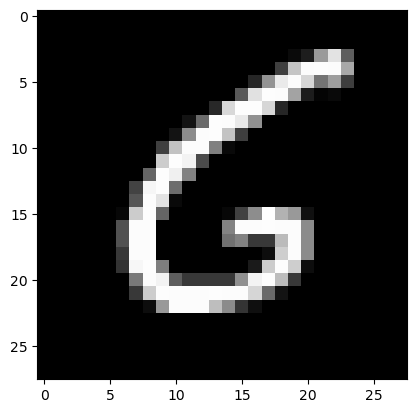

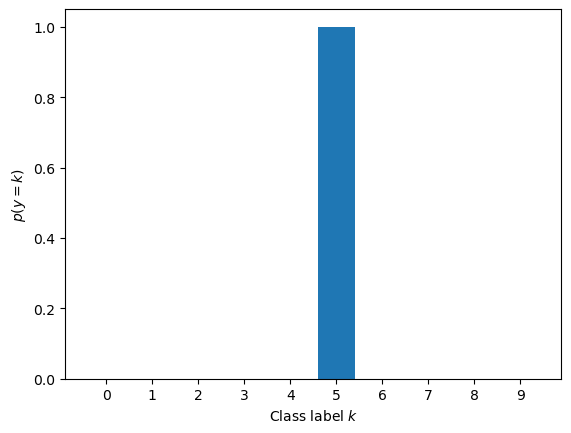

In [13]:
# test on an arbitrary image

ix = 7 ### CHANGE THIS INDEX TO VIEW A DIFFERENT IMAGE


plt.imshow(X[ix].squeeze())
plt.set_cmap("gray")

plt.figure()
with torch.no_grad():
    plt.bar(np.arange(10), dist.Categorical(logits=predict_class(X[ix:ix+1], params)).probs[0]);
    plt.xticks(np.arange(10))
    plt.xlabel("Class label $k$")
    plt.ylabel("$p(y=k)$")

In [14]:
print("Here are some indices of ones which were mis-classified and might be interesting to look at")

torch.arange(len(X))[predict_class(X, params).argmax(-1) != y]

Here are some indices of ones which were mis-classified and might be interesting to look at


tensor([ 2,  4,  6,  7,  9, 14, 15, 18, 25, 28, 36, 41, 45, 53, 55, 58, 62, 65,
        72, 77, 81, 88, 89, 91])

# Version 2: Using torch.nn

This will simplifiy things a lot.

Everything is very object-oriented, so that might be a bit confusing at first. Here are some usage examples.

In [15]:
import torch.nn as nn

In [16]:
# `nn.Linear` creates a linear layer which operates in parallel across a batch

layer = nn.Linear(D, H)
h = layer(X.reshape(-1, D))
print("X.shape =", X.shape) 
print("h.shape =", h.shape)

X.shape = torch.Size([100, 1, 28, 28])
h.shape = torch.Size([100, 200])


In [17]:
# you can iterate through the parameters.
# This model has a "weights" matrix and a "bias" vector

[a.numel() for a in layer.parameters()]

[156800, 200]

In [18]:
layer.weight.shape, layer.bias.shape

(torch.Size([200, 784]), torch.Size([200]))

In [19]:
# There are helper functions for creating lots of things, including nonlinearities

# First, you need to instantiate it
nonlinearity = nn.ReLU()

# The instantiated "layer" object is then a "callable", in python terminology, so it acts like a function
nonlinearity(h)

tensor([[0.1844, 0.2095, 0.4699,  ..., 0.3522, 0.0000, 0.1766],
        [0.0000, 0.0605, 0.0666,  ..., 0.2678, 0.0000, 0.1028],
        [0.0000, 0.2398, 0.5234,  ..., 0.0132, 0.0000, 0.0624],
        ...,
        [0.0000, 0.0601, 0.0000,  ..., 0.0200, 0.0000, 0.2100],
        [0.0000, 0.0000, 0.4292,  ..., 0.0000, 0.0000, 0.1762],
        [0.0000, 0.0000, 0.0855,  ..., 0.1633, 0.0000, 0.1051]],
       grad_fn=<ReluBackward0>)

### Chaining together operations

The easiest way to chain together operations is with `nn.Sequential`.

If the output of one computation feeds straight into the next one, then this will be quick and easy…

In [20]:

H2 = 20

network = nn.Sequential(nn.Flatten(),
                        nn.Linear(D, H),
                        nn.ReLU(),
                        nn.Linear(H, H2),
                        nn.ReLU(),
                        nn.Linear(H2, L))

In [21]:
# This itself is a submodule, which includes other submodules

network

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=200, bias=True)
  (2): ReLU()
  (3): Linear(in_features=200, out_features=20, bias=True)
  (4): ReLU()
  (5): Linear(in_features=20, out_features=10, bias=True)
)

In [22]:
# counting parameters recurses through all submodules

[a.numel() for a in network.parameters()]

[156800, 200, 4000, 20, 200, 10]

In [23]:
# [a.numel() for a in network[:3].parameters()]

# you can grab subnetworks by indexing:

network[:3]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=200, bias=True)
  (2): ReLU()
)

### The training code is almost identical

In [24]:
def run_epoch_nn(model, opt, reshape=True):
    train_loss = 0.0
    for X, y in train_loader:
        opt.zero_grad()
        if reshape:
            X = X.reshape(-1, D)
        y_hat = model(X)
        likelihood = dist.Categorical(logits=y_hat)
        loss = -likelihood.log_prob(y).mean()
        loss.backward()
        opt.step()
        train_loss += loss.item() * X.shape[0]
    return train_loss / len(train_loader.dataset)


### Here we'll evaluate it on an actual test set

In [25]:
mnist_test = MNIST(root='data/', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=500)

def check_test_accuracy(model, reshape=True):
    num_correct = 0
    for X, y in test_loader:
        with torch.no_grad(): # Gradients aren't needed just for test evaluation
            if reshape:
                X = X.reshape(-1, D)
            y_hat = model(X).argmax(-1)
        num_correct += (y_hat == y).numpy().sum()
    return num_correct / len(mnist_test)

In [26]:
opt_nn = torch.optim.Adam(network.parameters())

In [27]:
%%time 


run_epoch_nn(network, opt_nn)

CPU times: total: 13.1 s
Wall time: 5.92 s


0.4114156785731514

In [28]:
# After one epoch --- re-run the previous cell a few times and this will get better
check_test_accuracy(network)

0.9385

In [29]:
network.parameters()

<generator object Module.parameters at 0x0000021387E1E0B0>

### Example of a convolutional architecture, implemented a similar way

In [30]:
conv_net = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3),
                         nn.ReLU(),
                         nn.MaxPool2d(kernel_size=2),
                         nn.Conv2d(16, 32, kernel_size=3),
                         nn.ReLU(),
                         nn.MaxPool2d(kernel_size=2),
                         nn.Flatten(),
                         nn.Linear(800, L))

sum([a.numel() for a in conv_net.parameters()])
# conv_net(X).shape

12810

In [31]:
opt_conv = torch.optim.Adam(conv_net.parameters())

### On my laptop this is slow, but if you run this with a GPU it will be fast!

In [32]:
%%time 


run_epoch_nn(conv_net, opt_conv, reshape=False)

CPU times: total: 36.4 s
Wall time: 14.1 s


0.34156604155277215

In [33]:
# one-epoch accuracy
check_test_accuracy(conv_net, reshape=False)

0.9715

In [40]:
# compare to number of parameters in that feedforward network!
sum([a.numel() for a in conv_net.parameters()])

12810

# Version 3: Explicitly overloading `nn.Module`

If you want to do something more complicated, `nn.Sequential` won't cut it.

For that you actually have to override `nn.Module` yourself.

This is exactly the way that all of the `nn.Blah` modules are implemented: `nn.Sequential`, `nn.Linear`, `nn.Conv2d`, etc.

### Example: how would we add skip connections?

In [35]:
class SkipModel(nn.Module):
    
    def __init__(self, H, D):
        """
        In the .__init__() method, we define and instantiate any subnetworks 
        which might be useful.
        
        Basically: if it has parameters we will want to optimize, we will
        need to include it here, as `self.blah`. It will then be handled
        by the parent class, to make sure that the parameters appear when
        calling `.parameters()`.
        
        You can also add bare parameters, using e.g. 
        
        `self.param = nn.Parameter(torch.tensor(1.0))`
        
        That would add a single scalar trainable parameter, initialized at 1.0.


        """
        super().__init__()
        
        # This will be the first hidden layer
        self.fc1 = nn.Sequential(nn.Linear(D, H), nn.ReLU())
        
        # This will be the second hidden layer
        self.fc2 = nn.Sequential(nn.Linear(H, H), nn.ReLU())
        
        # This will be the output layer
        self.output = nn.Linear(H, L)
        
        # This will be a "skip" connection, which jumps from the first layer directly to the output
        self.skip = nn.Linear(H, L, bias=False)
        
    def forward(self, X):
        """
        The actual forward computation is defined here. This is run whenever you "call" the
        `nn.Module`, after it is instantiated.
        
        Here we will write down the computation required to run the model forward, calling
        our previously defined subnetworks
        
        """
        X = X.reshape(X.shape[0], -1)
        h1 = self.fc1(X)
        h2 = self.fc2(h1)
        y = self.output(h2) + self.skip(h1)
        return y

### This block will call `.__init__`

In [36]:
network = SkipModel(H, D)
network
sum([a.numel() for a in network.parameters()])

201210

### This block will call `.forward()`, implicitly

When we call `network(X)`, it is handled by our `.forward()` function we defined.

In [37]:
h = network(X)
h.shape

torch.Size([100, 10])

### Try out our skip-connection model

In [38]:
%%time

opt_skip = torch.optim.Adam(network.parameters())
run_epoch_nn(network, opt_skip)

CPU times: total: 16.9 s
Wall time: 6.67 s


0.2917661083986362

In [39]:
# Looks good?

check_test_accuracy(network)

0.9581